# Processing Chari 2015
- Processing library-on-library screens from [Chari et al. 2015](https://www.nature.com/articles/nmeth.3473)
- Description: A list of genes that would be considered of high value, encompassing ion channels, receptors and genes
in the cancer gene census19 was first derived...
These sites were then aligned against entire Hg19 genome sequence using SeqMap21, and the sites (i)
with no 3-nt off-targets in the genome and (ii) targeting the 5′-most exon were retained.
In total, sites were successfully generated for 1,362 genes for Cas9Sp

### Data Filters
1. pdna or etp > mean pdna -3 std

In [1]:
import pandas as pd
import gpplot
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import poola.core as pool

In [2]:
hek_data = pd.read_csv('../data/raw/Chari2015_sp_293T.csv')
target_annotations = pd.read_csv('../data/raw/Chari2015_sp_targets.csv')
oligos = pd.read_csv('../data/raw/Chari2015_sp_oligos.csv')

We'll first get our sgRNA and context sequences merged

In [3]:
clean_annotations = target_annotations.copy()
clean_annotations['Target Gene Symbol'] = (clean_annotations['GeneID']
                                           .str.split('_', expand=True)[0])
clean_annotations['Target ID'] = (clean_annotations['GeneID']
                                   .str.split('_', expand=True)
                              .apply(lambda x: '_'.join(x[0:3]), axis=1))
clean_annotations = clean_annotations.drop('GeneID', axis=1)
clean_annotations['sgRNA Sequence'] = clean_annotations['Sequence'].str[:20]

In [4]:
annotated_data = (hek_data
                  .rename({'Gene': 'Target ID'}, axis=1)
                  .merge(clean_annotations, how='inner', on='Target ID'))

In [5]:
first_oligo = oligos.loc[0, 'Oligonucleotide sequence']
first_context = 'GCAGCTGATTGGCCGAGGTCGATATGGAGC'
context_start = first_oligo.index(first_context)
print(context_start)
context_end = context_start + 30
assert first_oligo[context_start:context_end] == first_context

70


In [6]:
context_sequences = oligos.copy()
context_sequences['sgRNA Context Sequence'] = (context_sequences['Oligonucleotide sequence']
                                               .str[context_start:context_end])
context_sequences = (context_sequences[['Name', 'sgRNA Context Sequence']]
                     .rename({'Name': 'Target ID'},
                             axis=1))
annotated_context = (annotated_data
                     .merge(context_sequences,
                            how='inner', on='Target ID'))

We'll filter out any sgRNA that has lognorms 3 standard deviations below the mean.

In [7]:
# Use Poola
filtered_context = annotated_context.copy()
filtered_context['293T lognorm'] = pool.lognorm(filtered_context['293T (CAS9 + gRNA library only) - Total Read Count'])
filtered_context = pool.filter_pdna(filtered_context, ['293T lognorm'],
                                    z_low=-3, z_high=None)
print('Filtered: ' + str(annotated_context.shape[0] - filtered_context.shape[0]) + ' sgRNAs')

Filtered: 12 sgRNAs


<AxesSubplot:xlabel='293T (CAS9 + gRNA library only)', ylabel='Count'>

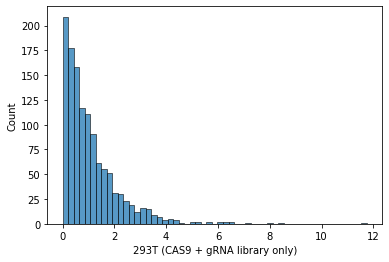

In [8]:
sns.histplot((filtered_context['293T (CAS9 + gRNA library only)']))

<AxesSubplot:xlabel='293T (CAS9 + gRNA library only)', ylabel='Count'>

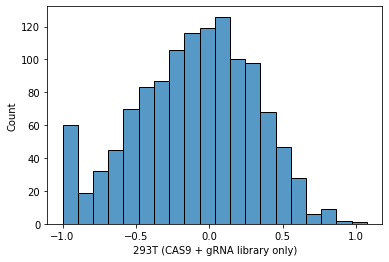

In [9]:
sns.histplot(np.log10((filtered_context['293T (CAS9 + gRNA library only)'] + 0.1)))

In [10]:
filtered_context['log10(293T mutation rate)'] = np.log10((filtered_context['293T (CAS9 + gRNA library only)'] + 0.1))

To validate we properly processed the data, we'll merge with Rule Set 2 scores

In [11]:
sg_list = filtered_context['sgRNA Sequence'].unique()
design_df = pd.read_parquet('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/People/Peter/gpp-annotation-files/sgRNA_design_9606_GRCh38_SpyoCas9_CRISPRko_Ensembl_20200401.parquet',
                            filters=[[('sgRNA Sequence', 'in', sg_list)]])

In [12]:
sgrna_designs = (filtered_context.merge(design_df, how='inner',
                                        on=['sgRNA Context Sequence']))

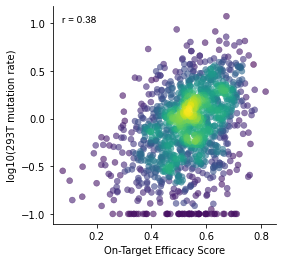

In [13]:
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(data=sgrna_designs, y='log10(293T mutation rate)', x='On-Target Efficacy Score')
gpplot.add_correlation(data=sgrna_designs, y='log10(293T mutation rate)', x='On-Target Efficacy Score', method='spearman')
sns.despine()

In [21]:
output_data = filtered_context[['sgRNA Sequence', 'sgRNA Context Sequence', 'log10(293T mutation rate)']].copy()
output_data['sgRNA Context Sequence'] = output_data['sgRNA Context Sequence'].str.upper()
output_data.shape

(1222, 3)

In [22]:
output_data.to_csv('../data/processed/Chari2015_activity.csv', index=False)